<a href="https://colab.research.google.com/github/mmagavi/FinalProject1291/blob/main/FinalProject1291.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Project: Classifying Brain Tumors With Convolutional Neural Networks and a Foundational Model**

VGG 19 Model

## **Importing the Data**

Importing the data from https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data

**cjdata.label:** 1 for meningioma, 2 for glioma, 3 for pituitary tumor

**cjdata.PID:** patient ID

**cjdata.image:** image data

**cjdata.tumorBorder:** a vector storing the coordinates of discrete points on tumor border.

		For example, [x1, y1, x2, y2,...] in which x1, y1 are planar coordinates on tumor border.
		It was generated by manually delineating the tumor border. So we can use it to generate
		binary image of tumor mask.

**cjdata.tumorMask:** a binary image with 1s indicating tumor region


In [33]:
# from google.colab import drive
# drive.mount('/content/drive')

In [34]:
# Importing and Downloading Images

!gdown 1p_q_wHJZQIEeinSUskvQHtqu88s2gfq8
!gdown 1EQRVW5M31GzZjEXnULygxpvBnIGOZ6WA
!gdown 1QxVOVJ89AHKQkbW-3Ftu-ajcDuzTTrIZ
!gdown 1A1dYyanURV6B7EPgI7VS-Y6tZuheEjJy
!unzip brainTumorDataPublic_22993064.zip -d tumor_data
!unzip brainTumorDataPublic_15332298.zip -d tumor_data
!unzip brainTumorDataPublic_7671532.zip -d tumor_data
!unzip brainTumorDataPublic_1766.zip -d tumor_data

Downloading...
From: https://drive.google.com/uc?id=1p_q_wHJZQIEeinSUskvQHtqu88s2gfq8
To: /content/brainTumorDataPublic_15332298.zip
100% 216M/216M [00:01<00:00, 112MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EQRVW5M31GzZjEXnULygxpvBnIGOZ6WA
To: /content/brainTumorDataPublic_22993064.zip
100% 232M/232M [00:03<00:00, 73.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QxVOVJ89AHKQkbW-3Ftu-ajcDuzTTrIZ
To: /content/brainTumorDataPublic_7671532.zip
100% 218M/218M [00:02<00:00, 93.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1A1dYyanURV6B7EPgI7VS-Y6tZuheEjJy
To: /content/brainTumorDataPublic_1766.zip
100% 214M/214M [00:01<00:00, 141MB/s]
Archive:  brainTumorDataPublic_22993064.zip
  inflating: tumor_data/2299.mat     
  inflating: tumor_data/2300.mat     
  inflating: tumor_data/2301.mat     
  inflating: tumor_data/2302.mat     
  inflating: tumor_data/2303.mat     
  inflating: tumor_data/2304.mat     
  inflating: tumor_data/2305.mat     
  inflati

In [35]:
#!ls tumor_data # Checking Data was loaded correctly into folder.

# **Creating a VGG19 Model, Evaluating & Training it on our Data**

*   Import packages and instantiate a model
*   Preprocessing images


In [36]:
%env CUDA_LAUNCH_BLOCKING=1 TORCH_USE_CUDA_DSA
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

#SETUP
import time
import os
import pickle
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 7]
plt.ion()
import cv2
import pickle
import numpy as np
from scipy.spatial.distance import pdist, squareform

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

from torchsummary import summary
import json
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)


# Instantiate a model, check the structure

vgg19 = models.vgg19(weights="IMAGENET1K_V1")
vgg19.to(device)
vgg19.eval()

summary(vgg19, (3, 224, 224))


env: CUDA_LAUNCH_BLOCKING=1 TORCH_USE_CUDA_DSA
Running on cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256

In [37]:
import h5py

image_path = "tumor_data/1571.mat" # using one image to see model works

# Open the .mat file using h5py
with h5py.File(image_path, 'r') as file:
    label = file['cjdata']['label'][()][0, 0]
    patient_id = file['cjdata']['PID'][()][0, 0]
    image_data = file['cjdata']['image'][()]
    tumor_border = file['cjdata']['tumorBorder'][()].flatten()

In [38]:
# Similar code to assignment 7
# Preprocessing images

!gdown 13teI_njgCL6oXbGFVYrDCyhkcOYEhOtj #imagenet_classes.json


def preprocess(image_data):
    data = np.repeat(image_data[..., np.newaxis], 3, -1)
    image = Image.fromarray((data * 255).astype(np.uint8))

    # Resize and normalize using PyTorch transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    normalized_image = transform(image)
    #print(normalized_image.shape)
    return normalized_image


PATH_TO_LABELS = 'imagenet_classes.json'
with open(PATH_TO_LABELS, 'r') as f:
    imagenet_classes = json.load(f)


def decode_preds(outputs, class_names=imagenet_classes):
  # Assuming outputs is the tensor of model outputs
  softmax_outputs = F.softmax(outputs, dim=1)
  probability, predicted_class = torch.max(softmax_outputs, dim=1)

  predicted_class_labels = [class_names[str(idx)] for idx in predicted_class.cpu().numpy()]
  probability_scores = probability.cpu().numpy()

  # Print or return the results
  for label, score in zip(predicted_class_labels, probability_scores):
      print(f'\nClass: {label}, Probability: {score}')


Downloading...
From: https://drive.google.com/uc?id=13teI_njgCL6oXbGFVYrDCyhkcOYEhOtj
To: /content/imagenet_classes.json
100% 32.6k/32.6k [00:00<00:00, 88.7MB/s]



Class: ladle, Probability: 0.1609952747821808


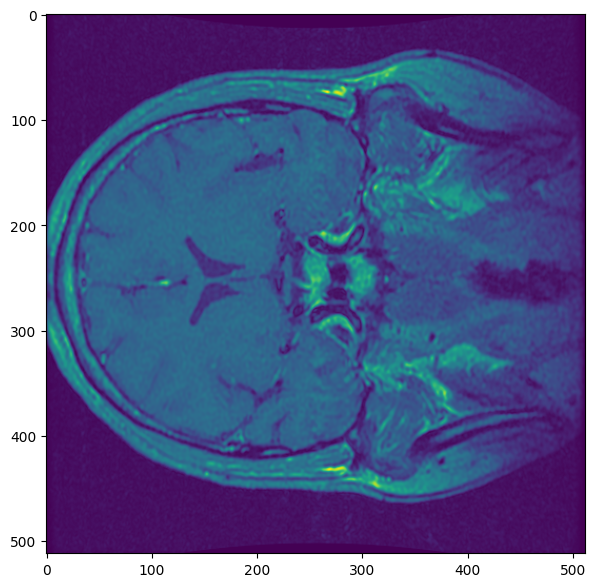

In [39]:
array = preprocess(image_data) #.to(device)

with torch.no_grad():
  vector = vgg19(array[None, :, :, :].cuda())

# Display the image

plt.imshow(image_data) #coloured by plt.imshow()
decode_preds(vector)

# Prediction is not correct, but not crazy

## **Fine tuning the model**

In [41]:
from sklearn.model_selection import train_test_split
import shutil

# Create a Training, Testing, and Validation set

path = "tumor_data"
file_paths = [os.path.join(path, file) for file in os.listdir(path)]
train_files, test_val_files = train_test_split(file_paths, test_size=0.2, random_state=42)
test_files, val_files = train_test_split(test_val_files, test_size=0.5, random_state=42)

def move_files(file_list, destination_folder):
    os.makedirs(destination_folder, exist_ok=True)
    for file in file_list:
        shutil.move(file, destination_folder)

# Move files to their folders
move_files(train_files, "tumor_data/train")
move_files(val_files, "tumor_data/validate")
move_files(test_files, "tumor_data/test")


Error: ignored

In [42]:
!ls tumor_data/test

1003.mat  1228.mat  1493.mat  1772.mat	2028.mat  2315.mat  2636.mat  2925.mat	505.mat  759.mat
1016.mat  124.mat   1496.mat  1774.mat	2031.mat  2320.mat  263.mat   2926.mat	507.mat  760.mat
1020.mat  1258.mat  1502.mat  177.mat	2035.mat  2327.mat  2641.mat  2941.mat	513.mat  763.mat
103.mat   125.mat   1516.mat  1781.mat	2036.mat  2340.mat  2642.mat  2975.mat	514.mat  773.mat
1041.mat  1269.mat  151.mat   1786.mat	2038.mat  235.mat   2650.mat  2982.mat	534.mat  774.mat
1042.mat  1273.mat  1524.mat  1790.mat	2044.mat  2365.mat  2651.mat  3000.mat	537.mat  776.mat
1049.mat  1275.mat  1540.mat  1793.mat	2048.mat  2373.mat  2654.mat  3019.mat	549.mat  783.mat
1054.mat  1280.mat  1544.mat  1794.mat	2059.mat  2382.mat  2667.mat  3046.mat	562.mat  78.mat
1055.mat  1282.mat  1552.mat  1798.mat	2068.mat  2394.mat  2674.mat  3049.mat	564.mat  808.mat
1057.mat  1283.mat  1570.mat  1802.mat	2077.mat  2401.mat  2678.mat  3056.mat	573.mat  812.mat
1070.mat  1295.mat  1575.mat  1805.mat	2081.mat  242

In [43]:
class CustomMatDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.file_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.mat')]
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]

        # Open the .mat file using h5py
        with h5py.File(file_path, 'r') as file:
            label = file['cjdata']['label'][()][0, 0]
            label = label - 1
            # patient_id = file['cjdata']['PID'][()][0, 0]
            image_data = file['cjdata']['image'][()]
            # tumor_border = file['cjdata']['tumorBorder'][()].flatten()

        if self.transform:
            image = self.transform(image_data)

        #return image, label.long() changed by maya
        return image, label

train_dataset = CustomMatDataset(folder_path='tumor_data/train', transform=preprocess)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomMatDataset(folder_path='tumor_data/test', transform=preprocess)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

validate_dataset = CustomMatDataset(folder_path='tumor_data/validate', transform=preprocess)
validate_loader = DataLoader(validate_dataset, batch_size=32, shuffle=True)


In [44]:
#class names
class_names = {
    0: "meningioma",
    1: "glioma",
    2: "pituitary tumor",
}

Creating a new model for fine-tuning

In [45]:
standard_vgg19 = models.vgg19(weights="IMAGENET1K_V1").to(device)

# Freeze the layers of the standard VGG19
for param in standard_vgg19.parameters():
    param.requires_grad = False

# Modify the model for 3-class classification of Brain images
# Remove the fully connected layers (classifier) on top
standard_vgg19.classifier = nn.Identity()

# Now create a new model with the features of the standard VGG19 and a new classifier
class NewVGG19(nn.Module):
    def __init__(self):
        super(NewVGG19, self).__init__()
        self.features = standard_vgg19.features
        self.avgpool = standard_vgg19.avgpool
        self.oldvgg = standard_vgg19
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 3),  #3 classes of tumours
            nn.Softmax(dim=1) # Added
        )

    def forward(self, x):
        x = self.oldvgg(x)
        #print(x.shape)
        x = self.classifier(x)
        return x

new_vgg19 = NewVGG19()

print(new_vgg19)

NewVGG19(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1),

Train the model

In [46]:
#torch.cuda.empty_cache()

In [47]:
# Helper function train() trains model for epoch epochs and returns a list of
# validation accuracies
def train(model, epochs, lr, trainloader, valloader, testloader):

  # Define the loss function and optimizer
  criterion = nn.CrossEntropyLoss().cuda()
  adam_optimizer = optim.Adam(model.parameters(), lr)

  accs = []
  model = model.cuda()
  for epoch in range(epochs):
      total_loss = 0

      for (batch_X, batch_y) in trainloader:
          # Zero the gradients
          adam_optimizer.zero_grad()
          # Forward pass
          outputs = model(batch_X.cuda())
          # Compute the loss
          loss = criterion(outputs, batch_y.long().cuda())
          # Backward pass
          loss.backward()
          # Update weights
          adam_optimizer.step()
          total_loss += loss.item()
      # Print average loss for the epoch
      print(f"Epoch {epoch + 1}, Loss: {total_loss / len(trainloader):.4f}")

      # Validation
      model.eval()
      with torch.no_grad():
        val_acc = []
        for (batch_X, batch_y) in valloader:
          val_outputs = model(batch_X.cuda())
          val_loss = criterion(val_outputs, batch_y.long().cuda())

          # If y_val is one-hot encoded
          _, val_preds = torch.max(val_outputs, 1)
          # _, yv = torch.max(batch_y, 1)

          val_acc.append((val_preds == batch_y.cuda()).float().mean().item())
        accs.append(np.mean(val_acc))

      print(f"Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {np.mean(val_acc):.4f}")

  # Testing
  model.eval()
  with torch.no_grad():

    test_acc = []

    for (batch_X, batch_y) in testloader:
      test_outputs = model(batch_X.cuda())
      test_loss = criterion(test_outputs, batch_y.long().cuda())

      # If y_val is one-hot encoded
      _, test_preds = torch.max(test_outputs, 1)
      # _, yv = torch.max(batch_y, 1)

      test_acc.append((test_preds == batch_y.long().cuda()).float().mean().item())

  print("TEST ACCURACY AND LOSS: ")
  print(f"TEST Loss: {test_loss.item():.4f}, TEST Accuracy: {np.mean(test_acc):.4f}")

  return accs


# Call train() for 15 epochs with lr 0.001
val_accs = train(new_vgg19, 20, 0.01, train_loader, validate_loader, test_loader)

print("Validation accuracies over epoch: ")
print(val_accs)

Epoch 1, Loss: 0.9017
Validation Loss: 0.8672, Validation Accuracy: 0.6747
Epoch 2, Loss: 0.8326
Validation Loss: 0.8672, Validation Accuracy: 0.7153
Epoch 3, Loss: 0.7969
Validation Loss: 0.7093, Validation Accuracy: 0.6936
Epoch 4, Loss: 0.7755
Validation Loss: 0.8667, Validation Accuracy: 0.7747
Epoch 5, Loss: 0.7008
Validation Loss: 0.6567, Validation Accuracy: 0.8645
Epoch 6, Loss: 0.6708
Validation Loss: 0.6974, Validation Accuracy: 0.8498
Epoch 7, Loss: 0.7020
Validation Loss: 0.7620, Validation Accuracy: 0.8352
Epoch 8, Loss: 0.6800
Validation Loss: 0.6567, Validation Accuracy: 0.8207
Epoch 9, Loss: 0.6391
Validation Loss: 0.5514, Validation Accuracy: 0.8938
Epoch 10, Loss: 0.6333
Validation Loss: 0.6041, Validation Accuracy: 0.8635
Epoch 11, Loss: 0.6276
Validation Loss: 0.7093, Validation Accuracy: 0.8842
Epoch 12, Loss: 0.6333
Validation Loss: 0.6041, Validation Accuracy: 0.8791
Epoch 13, Loss: 0.6552
Validation Loss: 0.6569, Validation Accuracy: 0.8645
Epoch 14, Loss: 0.641

In [ ]:
# Plot the validation accuracy over time

## **Notes on training model**

### **Testing out a variety of hyperparameters**

**Round 1: 10 epochs, lr = 0.01**

TEST ACCURACY AND LOSS:
Loss: 0.6628, Accuracy: 0.8764

Validation accuracies over epoch:
[0.7664473712444305, 0.871875, 0.8320723712444306, 0.8978618443012237, 0.8717105269432068, 0.861348682641983, 0.8873355269432068, 0.8853618443012238, 0.798848682641983, 0.876973682641983]

**Round 2: 10 epochs, lr = 0.005**

TEST ACCURACY AND LOSS:
Loss: 0.6075, Accuracy: 0.8663

Validation accuracies over epoch:
[0.8111842095851898, 0.8603618443012238, 0.864473682641983, 0.8603618443012238, 0.8728618443012237, 0.8799342095851899, 0.8707236826419831, 0.883223682641983, 0.892598682641983, 0.8726973712444306]

**Round 3: 10 epochs, lr = 0.05**

TEST ACCURACY AND LOSS:
Loss: 0.8848, Accuracy: 0.6667

Validation accuracies over epoch:
[0.6453947365283966, 0.5559210538864136, 0.5409539461135864, 0.5546052634716034, 0.5944078922271728, 0.6225328922271729, 0.6319078922271728, 0.6182565808296203, 0.6286184221506119, 0.6328947365283966]

**Round 4: 15 epochs, lr = 0.001**

TEST ACCURACY AND LOSS:

Loss: 0.7737, Accuracy: 0.6684

Validation accuracies over epoch:

[0.6276315808296203, 0.6319078922271728, 0.6276315808296203, 0.6297697365283966, 0.6276315808296203, 0.6297697365283966, 0.6297697365283966, 0.6319078922271728, 0.6276315808296203, 0.6276315808296203, 0.6361842095851898, 0.6297697365283966, 0.6233552634716034, 0.6340460538864136, 0.6319078922271728]

**Round 5: 20 epochs, lr = 0.01**

TEST ACCURACY AND LOSS:
Loss: 0.8292, Accuracy: 0.9035

Validation accuracies over epoch:
[0.6746710538864136, 0.7152960538864136, 0.6935855269432067, 0.7746710538864136, 0.864473682641983, 0.8498355269432067, 0.8351973712444305, 0.820723682641983, 0.89375, 0.8634868443012238, 0.8842105269432068, 0.8791118443012238, 0.864473682641983, 0.883223682641983, 0.8884868443012237, 0.8875, 0.889473682641983, 0.8916118443012238, 0.889473682641983, 0.89375]

Final accuracy for lr = 0.01, 20 epochs:
**0.89375**


In [ ]:
# New decode preds for brain data

def decode_brain_preds(outputs, class_names=class_names):
  # Assuming outputs is the tensor of model outputs
  softmax_outputs = F.softmax(outputs, dim=1)
  probability, predicted_class = torch.max(softmax_outputs, dim=1)

  predicted_class_labels = [class_names[idx] for idx in predicted_class.cpu().numpy()]
  probability_scores = probability.cpu().numpy()

  # Print or return the results
  for label, score in zip(predicted_class_labels, probability_scores):
      print(f'\nClass: {label}, Probability: {score}')


In [ ]:
# Checking classification

array = preprocess(image_data) #.to(device)

with torch.no_grad():
  vector = new_vgg19(array[None, :, :, :].cuda())

# Display the image

plt.imshow(image_data) #coloured by plt.imshow()
decode_brain_preds(vector)
print(label)
